In [1]:
# Add submodule paths
import sys
sys.path += ['./normalizing_flows', './baselines', './climdex']

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import utils.data as data_util
import utils.nn_util as nn
import xarray as xr
import gcsfs
import climdex.temperature as tdex
import climdex.precipitation as pdex
import logging
import tensorflow_probability as tfp
import utils.metrics as metrics
from regions import southeast_us, pacific_nw
from datasource import EraiRasDataLoader
from utils.plot import image_map_factory, prcp_cmap
from utils.preprocessing import remove_monthly_means
from utils.distributions import normal
from tqdm import tqdm

correlation = metrics.correlation_metric()

gcs = gcsfs.GCSFileSystem(project='thesis-research-255223', token='gcs.secret.json')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
#tf.autograph.set_verbosity(1)
#tf.config.experimental_run_functions_eagerly(True)
#tf.debugging.set_log_device_placement(True)

In [3]:
data = EraiRasDataLoader(gcs_bucket='erai-rasmussen', gcs_project='thesis-research-255223', auth='gcs.secret.json')
# era-interim
erai_deg1 = xr.open_zarr(data.erai('daily-1deg'), consolidated=True).clip(min=0.0, max=np.inf)
# 1-degree regridded rasmussen
ras_deg1 = xr.open_zarr(data.rasmussen('daily-1deg'), consolidated=True).clip(min=0.0, max=np.inf)
# 1/2-degree regridded rasmussen
ras_deg12 = xr.open_zarr(data.rasmussen('daily-1-2deg'), consolidated=True).clip(min=0.0, max=np.inf)
ras_deg14 = xr.open_zarr(data.rasmussen('daily-1-4deg'), consolidated=True).clip(min=0.0, max=np.inf)
ras_deg18 = xr.open_zarr(data.rasmussen('daily-1-8deg'), consolidated=True).clip(min=0.0, max=np.inf)
#ras_deg116 = xr.open_zarr(rasmussen('daily-1-16deg'), consolidated=True)
def get_train_test_splits(data_lo, data_hi, region_fn, scale):
    data_lo = region_fn(data_lo)
    data_hi = region_fn(data_hi, scale_factor=scale)
    lr_train = data_lo.isel(Time=slice(0,data_lo.Time.size-2*365))
    lr_test = data_lo.isel(Time=slice(data_lo.Time.size-2*365, data_lo.Time.size+1))
    hr_train = data_hi.isel(Time=slice(0,data_lo.Time.size-2*365))
    hr_test = data_hi.isel(Time=slice(data_lo.Time.size-2*365, data_lo.Time.size+1))
    return lr_train, lr_test, hr_train, hr_test

In [4]:
def plot_random_lr_hr_pairs(data_lr, data_hr, epsilon_prcp=1.0, i=None):
    if i is None:
        i = np.random.randint(0, data_lr.Time.size)
    maxt_lr = data_lr['MAXT'][i]
    maxt_hr = data_hr['MAXT'][i]
    prcp_lr = data_lr['PRCP'][i]
    prcp_hr = data_hr['PRCP'][i]
    fig, axs, plot_fn = image_map_factory(2, 2, figsize=(6,4))
    pmap = prcp_cmap()
    plot_fn(axs[0,0], maxt_lr, maxt_lr.lat, maxt_lr.lon, title='ERA-I, max temperature', cmap='viridis')
    cs = plot_fn(axs[0,1], maxt_hr, maxt_hr.lat, maxt_hr.lon, title='WRF-8, max temperature', cmap='viridis')
    fig.colorbar(cs, ax=axs[0].ravel().tolist(), orientation='vertical', shrink=0.6, pad=0.01).set_label('max temperature (K)')
    plot_fn(axs[1,0], prcp_lr, prcp_lr.lat, prcp_lr.lon, title='ERA-I, precipitation', cmap=pmap)
    cs = plot_fn(axs[1,1], prcp_hr, prcp_hr.lat, prcp_hr.lon, title='WRF-8, precipitation', cmap=pmap)
    fig.colorbar(cs, ax=axs[1].ravel().tolist(), orientation='vertical', shrink=0.6, pad=0.01).set_label('precipitation (mm)')
    return fig, i

<xarray.DataArray 'Time' ()>
array('2012-08-19T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    Time     datetime64[ns] 2012-08-19


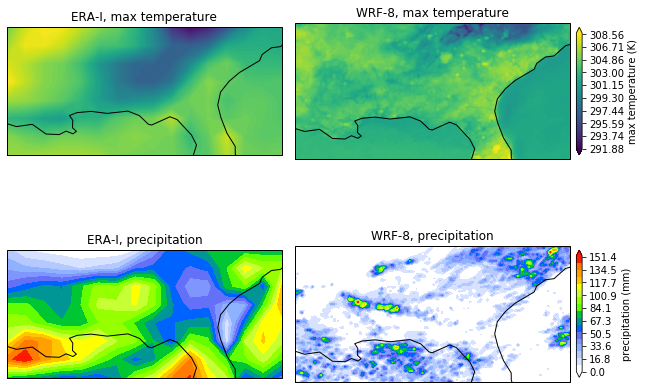

In [5]:
lr_train, lr_test, hr_train, hr_test = get_train_test_splits(erai_deg1, ras_deg18, southeast_us, scale=8)
fig, i = plot_random_lr_hr_pairs(lr_test, hr_test, i=322)
print(hr_test.Time[i])
plt.show()

### Bicubic interpolation

In [6]:
lr_train, lr_test, hr_train, hr_test = get_train_test_splits(erai_deg1, ras_deg14, southeast_us, scale=4)
X_train, monthly_means_lr = remove_monthly_means(lr_train['MAXT'])
y_train, monthly_means_hr = remove_monthly_means(hr_train['MAXT'])
y_test, _ = remove_monthly_means(hr_test['MAXT'])

### BCSD

In [12]:
# Southeast-US MAXT
lr_train, lr_test, hr_train, hr_test = get_train_test_splits(erai_deg1, ras_deg14, southeast_us, scale=4)
indices = tdex.indices('Time', convert_units_fn=lambda x: x+273.15)
uri = 'generative-downscaling-artifact-store/bcsd-final/558b55bddd6c44cfad5b8b979072e99f/artifacts/data/metrics.npz'
with gcs.open(uri) as f:
    bcsd_metrics = np.load(f)
    txx_pred = bcsd_metrics['txx']
    txn_pred = bcsd_metrics['txn']
    txid_pred = bcsd_metrics['txid']
    txsd_pred = bcsd_metrics['txsd']
    maxt_hr_test = hr_test['MAXT'].expand_dims({'chan': 1}, axis=-1)
    txx_true = indices.monthly_txx(maxt_hr_test)
    txn_true = indices.monthly_txn(maxt_hr_test)
    txid_true = indices.annual_icing_days(maxt_hr_test)
    txsd_true = indices.annual_summer_days(maxt_hr_test)
    txx_corr = correlation(txx_true.values, txx_pred).numpy()
    txn_corr = correlation(txn_true.values, txn_pred).numpy()
    txsd_corr = correlation(txsd_true.values, txsd_pred).numpy()
    txid_corr = correlation(txid_true.values, txid_pred).numpy()

correlation, txx: 0.9767088499369351 txn: 0.9793036177623053 txsd: 0.9990882115629296 txid: 0.018174177976978137


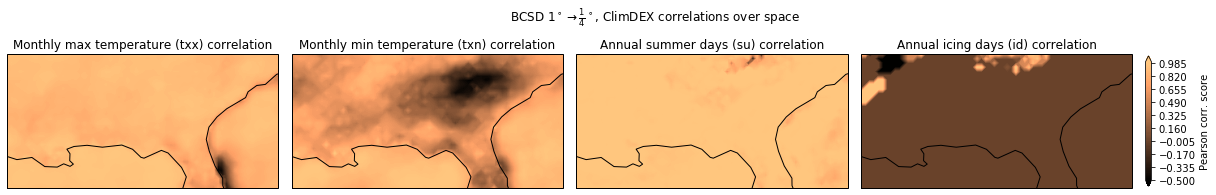

In [17]:
print(f'correlation, txx: {np.mean(txx_corr)} txn: {np.mean(txn_corr)} txsd: {np.mean(txsd_corr)} txid: {np.mean(txid_corr)}')
fig, axs, plot_fn = image_map_factory(1, 4, figsize=(6,4))
plot_fn(axs[0], txx_corr.squeeze(), hr_test.lat, hr_test.lon, title='Monthly max temperature (txx) correlation', cmap='copper')
plot_fn(axs[1], txn_corr.squeeze(), hr_test.lat, hr_test.lon, title='Monthly min temperature (txn) correlation', cmap='copper')
plot_fn(axs[2], txsd_corr.squeeze(), hr_test.lat, hr_test.lon, title='Annual summer days (su) correlation', cmap='copper')
cs = plot_fn(axs[3], txid_corr.squeeze(), hr_test.lat, hr_test.lon, title='Annual icing days (id) correlation', cmap='copper')
fig.colorbar(cs, ax=axs.ravel().tolist(), orientation='vertical', shrink=0.6, pad=0.01).set_label('Pearson corr. score')
fig.suptitle('BCSD $1^\\circ \\rightarrow \\frac{1}{4}^\\circ$, ClimDEX correlations over space', y=0.9)
plt.show()